In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from scipy.stats import t
from tensorflow.keras import layers
from tensorflow import keras

*Objectives:*

- Explore recurrent neural networks and LSTMs
- Implement an LSTM for temperature forecasting

# Multi-layer perceptron

- Multi-layer perceptrons (MLPs) are a type of neural network that consists of multiple layers of interconnected neurons, with each neuron performing a weighted sum of its inputs and passing the result through a non-linear activation function to produce its output.

- The inputs to an MLP are typically vector values, and the output of the network is also a vector of values, which may represent class probabilities or numerical predictions.

- The intermediate layers in an MLP, known as **hidden layers**, allow the network to learn complex, non-linear relationships between the inputs and the outputs. Each neuron in a hidden layer receives input from all the neurons in the previous layer and produces output that is passed to all the neurons in the next layer.

- During training, an MLP is optimized by adjusting the weights and biases of the neurons using backpropagation. This involves computing the error between the network's predicted output and the desired output, and then using this error to adjust the weights and biases to improve the network's performance.

In TensorFlow, a MLP is implemented by stacking several `Dense` layers which compute the following: `output = activation(dot(input, kernel) + bias)`. 

- `activation` is the element-wise activation function passed as the activation argument
- `kernel` is a weights matrix created by the layer which is training using backpropagation 
- `bias` is a bias vector created by the layer (only applicable if use_bias is True)

# Recurrent neural networks and Back-Propagation Through Time (BPTT)

A recurrent neural network (RNN) is a special type of artificial neural network adapted to work for time series data or data that involves sequences. Ordinary feedforward neural networks are only meant for data points that are independent of each other. However, if we have data in a sequence such that one data point depends upon the previous data point, we need to modify the neural network to incorporate the dependencies between these data points. RNNs have the concept of “memory” that helps them store the states or information of previous inputs to generate the next output of the sequence.

For a RNN: 

$$L(x_1, \ldots, x_T, y_1, \ldots, y_T, w_h, w_o) = \frac{1}{T}\sum_{t=1}^T l(y_t, o_t)$$

with:

- $h_t = f(x_t, h_{t-1}, w_h)$

- $o_t = g(h_t, w_o)$

where $f$ and $g$ are transformations of the hidden layer and the output layer, respectively. Hence, we have a chain of values $\{\ldots, (x_{t-1}, h_{t-1}, o_{t-1}), (x_{t}, h_{t}, o_t), \ldots\}$ that depend on each other via recurrent computation.

The discrepancy between the output and the desired target is then evaluated by an objective function across all the time steps ($L$).

For backpropagation, matters are a bit trickier, especially when we compute the gradients with regard to the parameters $w_h$ of the objective function. To be specific, by the chain rule:

$$\frac{\partial L}{\partial w_h}  = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial w_h}  = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial o_t} \frac{\partial g(h_t, w_o)}{\partial h_t}  \frac{\partial h_t}{\partial w_h}$$

The first and the second factors of the product are easy to compute. The first factor $\partial h_t/\partial w_h$ is where things get tricky, since we need to recurrently compute the effect of the parameter $w_h$ on $h_t$. According to the recurrent relation, $h_t$ depends on both $h_{t-1}$ and $w_h$, $h_{t-1}$ also depending on $w_h$.

$$\frac{\partial h_t}{\partial w_h}= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h} +\frac{\partial f(x_{t},h_{t-1},w_h)}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_h}$$

For sequences {$a_t$}, {$b_t$} and {$c_t$} satifying $a_0 = 0$, $\forall t \geq 1, a_t = b_t + c_ta_{t-1}$, we have: 

$$a_{t}=b_{t}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}c_{j}\right)b_{i}$$

Applying the above with:

- $a_t = \frac{\partial h_t}{\partial w_h}$

- $b_t = \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h}$

- $c_t = \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial h_{t-1}}$

we obtain:

$$\frac{\partial h_t}{\partial w_h}=\frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_h)}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_h)}{\partial w_h}$$

![Alt text](RNN.png)

Example:

In [25]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = keras.Sequential()
    model.add(layers.SimpleRNN(
        hidden_units, 
        input_shape=input_shape,
        activation=activation[0]))
    model.add(layers.Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

rnn = create_RNN(2, 1, (3,1), activation=['linear', 'linear'])

In [26]:
wx = rnn.get_weights()[0]
wh = rnn.get_weights()[1]
bh = rnn.get_weights()[2]
wy = rnn.get_weights()[3]
by = rnn.get_weights()[4]

print('wx = ', wx, ' wh = ', wh, ' bh = ', bh, ' wy =', wy, 'by = ', by)

wx =  [[-0.8037107 -1.126148 ]]  wh =  [[-0.34551668 -0.9384126 ]
 [ 0.9384126  -0.34551668]]  bh =  [0. 0.]  wy = [[ 0.0822494 ]
 [-0.60433185]] by =  [0.]


In [27]:
x = np.array([1, 2, 3])
# Reshape the input to the required sample_size x time_steps x features
x_input = np.reshape(x,(1, 3, 1))
y_pred_model = rnn.predict(x_input)

m = 2
h0 = np.zeros(m)
h1 = np.dot(x[0], wx) + h0 + bh
h2 = np.dot(x[1], wx) + np.dot(h1,wh) + bh
h3 = np.dot(x[2], wx) + np.dot(h2,wh) + bh
o3 = np.dot(h3, wy) + by

print('h1 = ', h1,'h2 = ', h2,'h3 = ', h3)
 
print("Prediction from network ", y_pred_model)
print("Prediction from our computation ", o3)

h1 =  [[-0.8037107  -1.12614799]] h2 =  [[-2.38651741 -1.1089808 ]] h3 =  [[-2.62723209 -0.75573456]]
Prediction from network  [[0.24062613]]
Prediction from our computation  [[0.2406262]]


*Problem:* 

RNNs suffer from vanishing / exploding gradient problem.

$$\frac{\partial h_t}{\partial w_h}=\frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_h)}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_h)}{\partial w_h}$$

In a vanilla RNN, we have:

- $\mathbf{h}_t = \mathbf{W}_{hx} \mathbf{x}_t + \mathbf{W}_{hh} \mathbf{h}_{t-1}$

- $\mathbf{o}_t = \mathbf{W}_{qh} \mathbf{h}_{t}$

$\implies \nabla_{h_{t-1}} h_t = W_{hh}$

$$\frac{\partial L}{\partial \mathbf{W}_{hx}}
= \sum_{t=1}^T \text{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_{hx}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{x}_t^\top\\
\frac{\partial L}{\partial \mathbf{W}_{hh}}
= \sum_{t=1}^T \text{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_{hh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{h}_{t-1}^\top$$

with:

$$\frac{\partial L}{\partial \mathbf{h}_t}= \sum_{i=t}^T {\left(\mathbf{W}_{hh}^\top\right)}^{T-i} \mathbf{W}_{qh}^\top \frac{\partial L}{\partial \mathbf{o}_{T+t-i}}$$ 

Pascanu & al. (2012) note that, using the previous equation, the gradient might explode if the spectral radius of the recurrent weight matrix exceeds 1, and the gradient might vanish if it is below 1.

## LSTM (Long-Short Term Memory)

LSTMs resemble standard recurrent neural networks but here each ordinary recurrent node is replaced by a memory cell. Each memory cell contains an internal state, i.e., a node with a self-connected recurrent edge of fixed weight 1, ensuring that the gradient can pass across many time steps without vanishing or exploding.

The term “long short-term memory” comes from the following intuition. Simple recurrent neural networks have long-term memory in the form of weights. The weights change slowly during training, encoding general knowledge about the data. They also have short-term memory in the form of ephemeral activations, which pass from each node to successive nodes. The LSTM model introduces an intermediate type of storage via the memory cell.

The key distinction between vanilla RNNs and LSTMs is that the latter support gating of the hidden state. This means that we have dedicated mechanisms for when a hidden state should be updated and also when it should be reset. These mechanisms are learned and they address the concerns listed above. For instance, if the first token is of great importance we will learn not to update the hidden state after the first observation. Likewise, we will learn to skip irrelevant temporary observations. Last, we will learn to reset the latent state whenever needed. We discuss this in detail below.

Mathematically, suppose that there are h hidden units, the batch size is n, and the number of inputs is d. Thus, the input is $X_t \in R^{n.d}$ and the hidden state of the previous time step is $H_{t-1} \in R^{n.h}$.Correspondingly, the gates at time step are defined as follows: the input gate is $I_t \in R^{n.h}$, the forget gate is $F_t \in R^{n.h}$, and the output gate is $O_t \in R^{n.h}$. They are calculated as follows:

$\mathbf{I}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i)$

$\mathbf{F}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f)$

$\mathbf{O}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o)$

We use sigmoid functions to map the input values to the interval $(0,1)$.

The input node is designed as follows:

$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c)$

In LSTMs, the input gate governs how much we take new data into account via the input node, and the forget gate addresses how much of the old cell internal state we retain. Using the Hadamard (elementwise) product operator we arrive at the following update equation:

$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t$

The hidden state is the updated as:

$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t)$

![Alt text](lstm.png)

Notice that the *cell memory* is now implemtend via $C_t$ and not via $H_t$, as gradient propagate through time using $C_t$, hence this solves the vanishing / exploding gradient issues as $\nabla_{C_{t-1}} {C_t} = F_t$ which is modulated during the training of the network. If $F_t = 0$, we forget all past information. If $F_t = 1$, we keep all past information.

# Display configuration and annex functions

In [42]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Data 

In this section, we look at the distribution of the data.

In [66]:
nyc_temp = pd.read_csv('nyc_temperature.csv', index_col = 0, parse_dates=True)
nyc_temp.index = pd.to_datetime(nyc_temp.index).to_period('D')

In [69]:
nyc_temp.head()

,temp_f
date,
2015-05-14,59.7
2015-05-15,63.2
2015-05-16,65.2
2015-05-17,70.4
2015-05-18,63.6


Text(0.5, 1.0, 'Daily temperature - NYC')

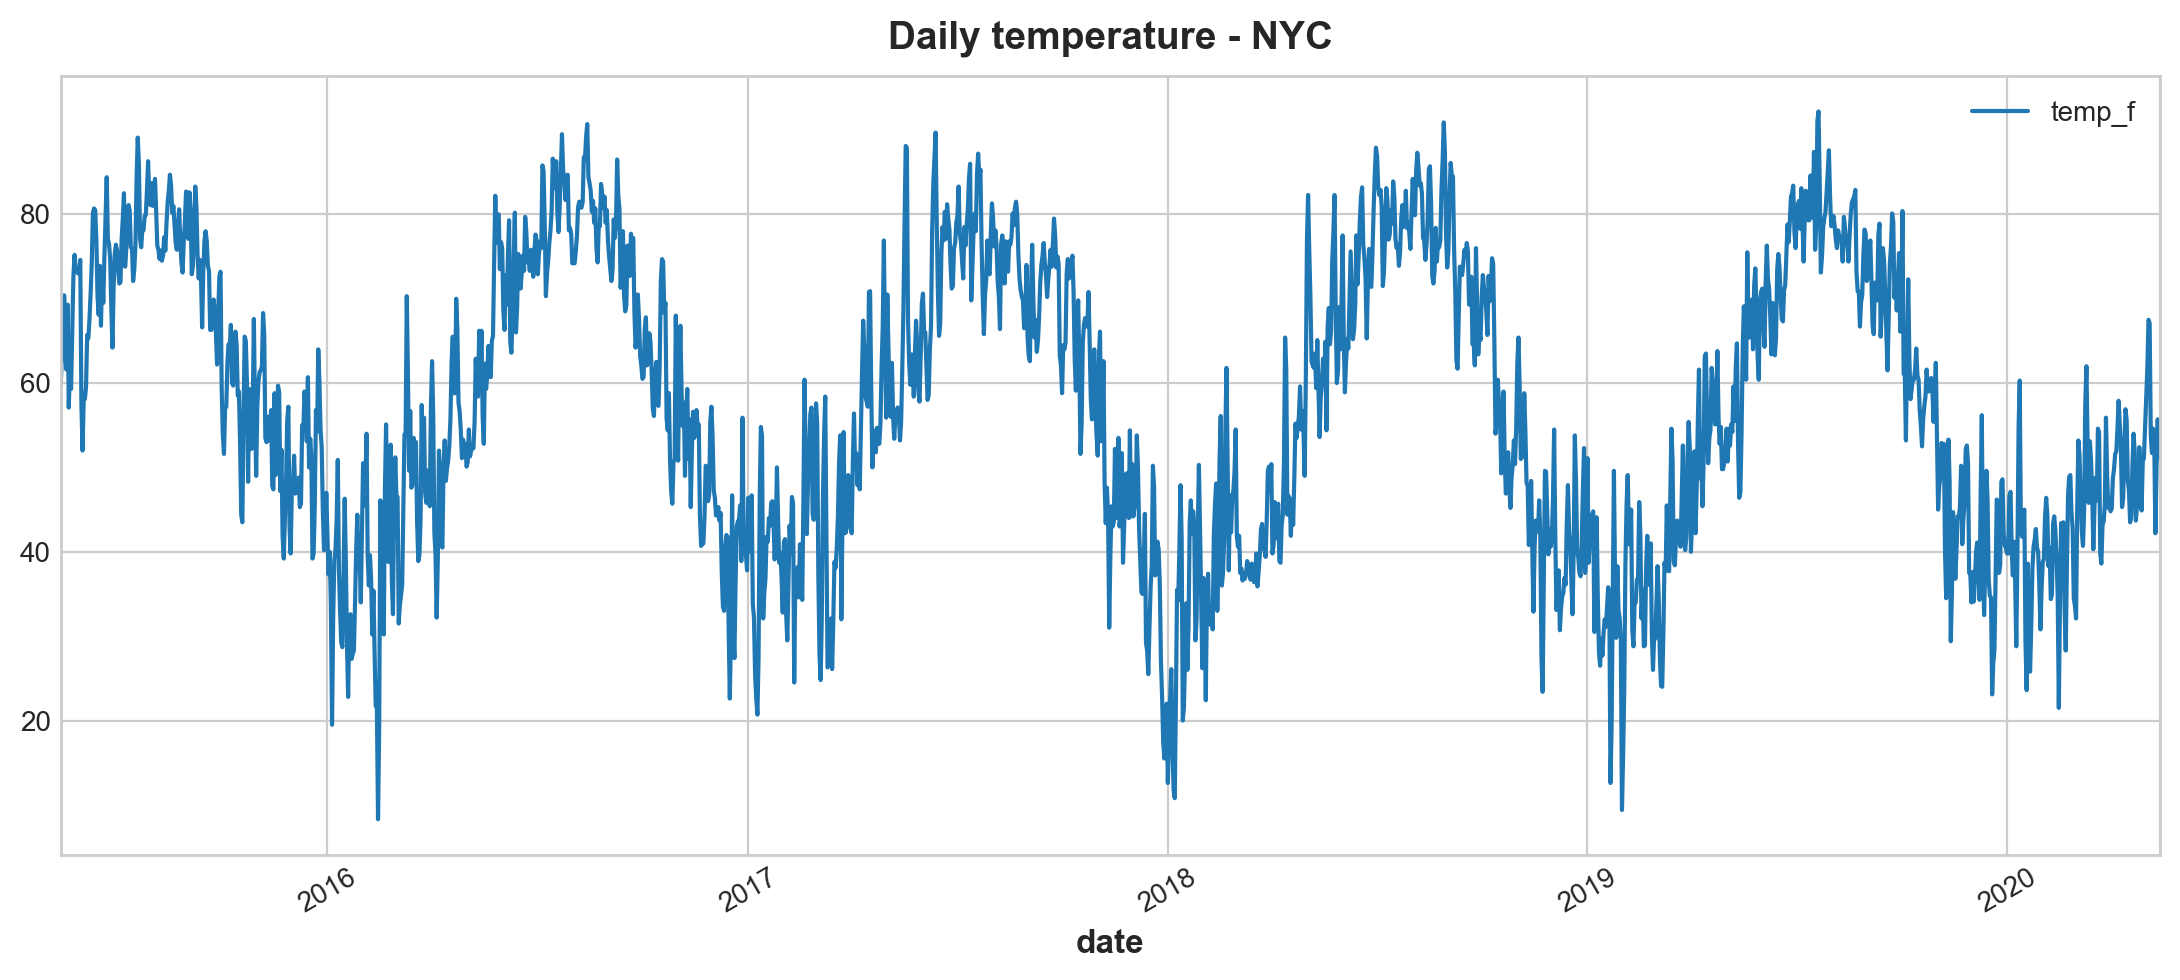

In [70]:
nyc_temp.plot(rot = 30)
plt.title('Daily temperature - NYC')

It is clear from this plot that the temperature data in NYC displays seasonality, as expected. We expect the temperature data to have annual seasonality.

In [71]:
nyc_temp.describe()

,temp_f
count,1827.000000
mean,57.375588
std,16.912102
min,8.300000
25%,43.700000
50%,56.600000
75%,73.100000
max,92.200000


In [90]:
nyc_temp.isna().sum()

temp_f    0
dtype: int64

(1827, 1)

In [96]:
n_train = nyc_temp.shape[0]-365

In [97]:
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=nyc_temp.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in nyc_temp.index

In [98]:
full_data = pd.concat([nyc_temp, X], axis=1).values

In [99]:
look_back = 60
X = []
Y = []
target_variable = full_data[:, 0]
for i in range(look_back, len(target_variable)):
    X.append(full_data[i-look_back:i, :])
    Y.append(target_variable[i])
X, Y = np.array(X), np.array(Y)

In [100]:
X.shape

(1767, 60, 29)

In [101]:
Y.shape

(1767,)

In [102]:
# we need to reshape Y to a 2D array
Y = Y.reshape(-1, 1)

In [104]:
X_train = X[:n_train, ...]
X_test = X[n_train:, ...]
Y_train = Y[:n_train, ...]
Y_test = Y[n_train:, ...]

In [106]:
model = keras.Sequential()
model.add(layers.LSTM(units = 150, return_sequences = False, input_shape = (X.shape[1], X.shape[2])))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1))
model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.01), loss='mean_squared_error')
history = model.fit(X_train, Y_train, epochs=20, batch_size=8, validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 1462 samples, validate on 305 samples
Epoch 1/20
1462/1462 [==============================] - 24s 17ms/sample - loss: 2216.2924 - val_loss: 1331.3674
Epoch 2/20
1462/1462 [==============================] - 20s 13ms/sample - loss: 1332.3309 - val_loss: 887.0650
Epoch 3/20
1462/1462 [==============================] - 21s 14ms/sample - loss: 969.1586 - val_loss: 668.8227
Epoch 4/20
1462/1462 [==============================] - 21s 15ms/sample - loss: 761.7351 - val_loss: 518.4041
Epoch 5/20
1462/1462 [==============================] - 21s 14ms/sample - loss: 636.9296 - val_loss: 430.3259
Epoch 6/20
1462/1462 [==============================] - 26s 18ms/sample - loss: 540.2220 - val_loss: 370.8996
Epoch 7/20
1462/1462 [==============================] - 28s 19ms/sample - loss

$RMSE_{LSTM} = 15.16 > RMSE_{linear regression} = 7.94$ 